Import the required packages and set up the Spark session.

In [ ]:
# install required packages
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
%pip install -q pyspark
%pip install -q findspark
%pip install -q joblibspark
%pip install -q spacy
%pip install -U scikit-learn
!python -m spacy download en_core_web_sm

In [3]:
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.8/dist-packages/pyspark'

In [4]:
from pyspark.sql import SparkSession
import pyspark;
spark = SparkSession.builder.appName('612Project').getOrCreate();

Note: We will be using Spark for GridSearchCV only. This appears to be the only sklearn method currently supported by Spark. The remaining code will be executed using Pandas dataframes.

Load the CSV file (n=1000 samples) containing our manual labels as the target vector

In [5]:
# This notebook was originally run in Google colab due to better hardware performance than Databricks and local machines.
# This code should not be run locally (it will not work)

# from google.colab import files
# uploaded = files.upload()

In [ ]:
import pandas as pd

df = pd.read_csv("GH-React.csv")

#keep only the columns we need
df = df[['title','author_association','body','Target']]

In [ ]:
print("Shape:", df.shape)
df.columns

## Machine Learning Pipeline
### Stage 1
The preprocess() function is defined below. It takes in a String formatted as Markdown from GitHub and pre-processes it to return a new string ready for the next stages in our ML Pipeline.

In [ ]:
import re

def preprocess(text):
    stripped = text.lower()

    # remove all headings, bold text, and HTML comments from the Markdown text.
    # These items have all been used by the React team in their issue templates on GitHub
    headings_pattern = r'(<=\s|^)#{1,6}(.*?)$'
    bold_pattern = r'\*\*(.+?)\*\*(?!\*)'
    comments_pattern = r'<!--((.|\n)*?)-->'
    combined_pattern = r'|'.join((headings_pattern, bold_pattern, comments_pattern))

    stripped = re.sub(combined_pattern, '', stripped)

    # find all URLs in the string, and then remove the final directory from each to leave the general URL form
    # there may be useful patterns based on what URLs issues are commonly linking to
    url_pattern = re.compile(r'(https?://[^\s]+)')
    for url in re.findall(url_pattern, stripped):
        new_url = url.rsplit("/", 1)[0]
        stripped = stripped.replace(url, new_url)

    non_alpha_pattern = r'[^A-Za-z ]+'
    stripped = re.sub(non_alpha_pattern, '', stripped)    
    
    return ' '.join(stripped.split())

In [ ]:
#convert body and title column to unicode, there were some issues with processing
df['body'] = df['body'].astype('U')
df['title'] = df['title'].astype('U')

Test the preprocess function on a sample post to ensure that it works as expected:

In [ ]:
test = df['body'][4]
preprocess(test)

### Stage 2
Split the data into training (80%) and validation(20%) sets. We will stratify based on the label since our dataset is imbalanced.

In [ ]:
y = df['Target']
X = df.drop(['Target'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1)

print(X_train.shape)
print(X_val.shape)

### Stage 3
Create a TF-IDF features matrix using TfidfVectorizer from sklearn applied to the title and body of each issue.

We will additionally add in the feature 'author_association' from the GitHub issue, as there may be a correlation between Members/Collaborators/Contributors submitting more valid bugs/feature requests than "None" users.

While lemmatization could have been done earlier in the pre-processsing stage, it is more efficient to lemmatize at this point in a custom_tokenizer() function passed to TfidfVectorizer since tokenization is part of both processses.

First, define the tokenizer and vectorizer:

In [ ]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")

# create a custom tokenizer using the spacy document processing pipeline
def custom_tokenizer(document):
    ppd = preprocess(document)
    doc = nlp(ppd)
    return [token.lemma_ for token in doc]

tfidfvect = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), min_df=3)

We will also use one-hot-encoding on the author-association feature

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# use one hot encoder to transform the author_association to a feature set
ohe = OneHotEncoder()

Create the features matrix using a ColumnTransformer to create a pipeline with the different feature generation methods. We will use a separate vectorizer on the body and title to produce a different set of features for each. The tokens in the title may hold different importance than the same token in the body.

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [("title", tfidfvect, "title"),
     ("body", tfidfvect, "body"),
     ("ohe", ohe, ['author_association'])]
)

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
X_train_trans.shape

Perform an initial analysis on our model to see how our train and validation scores look (spoiler: not great)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha=0.0001)
mnb.fit(X_train_trans, y_train)

X_val_trans = ct.transform(X_val)
print("Train score: {:.2f}".format(mnb.score(X_train_trans, y_train)))
print("Validation score: {:.2f}".format(mnb.score(X_val_trans, y_val)))

Train score: 0.72
Validation score: 0.52


Look at the features with the lowest and highest idf from the 'body' column just to see if things look reasonable. The features with the lowest idf are what we would think of as 'stop words', so this seems intuitive.

In [ ]:
import numpy as np
sorted_by_idf = np.argsort(ct.named_transformers_.body.idf_)
feature_names = np.array(ct.named_transformers_.body.get_feature_names_out())

print("Features with lowest idf:\n{}".format(feature_names[sorted_by_idf[:20]]))
print("Features with highest idf:\n{}".format(feature_names[sorted_by_idf[-20:]]))

Features with lowest idf:
['the' 'be' 'to' 'a' 'not' 'in' 'and' 'this' 'I' 'react' 'it' 'of' 'do'
 'use' 'version' 'that' 'for' 'with' 'component' 'have']
Features with highest idf:
['standalone' 'eject' 'start build' 'either the' 'start with' 'state I'
 'devdependencie' 'state dispatch' 'during the' 'down the' 'still be'
 'still have' 'do in' 'dispatch type' 'discussion' 'disabled' 'diff'
 'subcomponent' 'state for' 'your time']


### TODO: See if we can visualize our text features to make sure it seems logical. Take an example from Chapter 7 in ML book.

### Stage 4
#### Grid Search for optimizing model

Use grid search to find potentially better model parameters:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV

####### import joblibspark for gridsearch
from joblibspark import register_spark
from sklearn.utils import parallel_backend
register_spark() # register spark backend

pipe = make_pipeline(ct, MultinomialNB())

param_grid = {"multinomialnb__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
                "columntransformer__body__ngram_range": [(1, 2), (1, 3)],
                "columntransformer__body__min_df": [3, 5]
              }


In [ ]:
# WARNING: Running this cell will run GridSearch. Skip to loading the pickle file if you want to save time.

with parallel_backend('spark',n_jobs=-1):
  grid = GridSearchCV(pipe, param_grid, cv=5)
  grid.fit(X_train, y_train)

In [ ]:
# write the grid object to a file so that it can be loaded in a different session for analysis
import dill as pickle
pickle.dump(grid, open("grid.pkl", "wb"))


In [ ]:
# this was originally run on Google colab as their hardware is better than mine
# download the results from colab to my local drive
# from google.colab import files
# files.download('grid.pkl')

In [ ]:
# load the grid variable back from file to continue using it's
# contents for analysis in future sessions
grid = pickle.load(open("grid.pkl", "rb"))

In [ ]:
grid_cv_results = pd.DataFrame(grid.cv_results_)
grid_cv_results.to_csv('grid_cv.csv', index=False)
# from google.colab import files
# files.download('grid_cv.csv')

In [ ]:
print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best parameters: {'columntransformer__body__min_df': 3, 'columntransformer__body__ngram_range': (1, 2), 'multinomialnb__alpha': 0.1}
Best cross-validation score: 0.55


### Stage 5
Use the best parameters generated by grid transform to re-train and validate our model with the X_val and y_val data we saved in stage 3:

In [ ]:
tfidfvect = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), min_df=3)

ct = ColumnTransformer(
    [("title", tfidfvect, "title"),
     ("body", tfidfvect, "body"),
     ("ohe", ohe, ['author_association'])]
)

X_train_trans = ct.fit_transform(X_train)

mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train_trans, y_train)

X_val_trans = ct.transform(X_val)
print("Train score: {:.2f}".format(mnb.score(X_train_trans, y_train)))
print("Validation score: {:.2f}".format(mnb.score(X_val_trans, y_val)))

Train score: 0.93
Validation score: 0.55


Our model doesn't perform great, but at least it beats random chance by about 20%!

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X, y)

print("Score based on chance: {:.2f}".format(dummy_clf.score(X, y)))

Score based on chance: 0.35


# Analysis

In [ ]:
logreg.classes_

array(['Bug', 'Feature', 'Other', 'Support'], dtype=object)

TRAINING RESULTS:

Confusion Matrix:


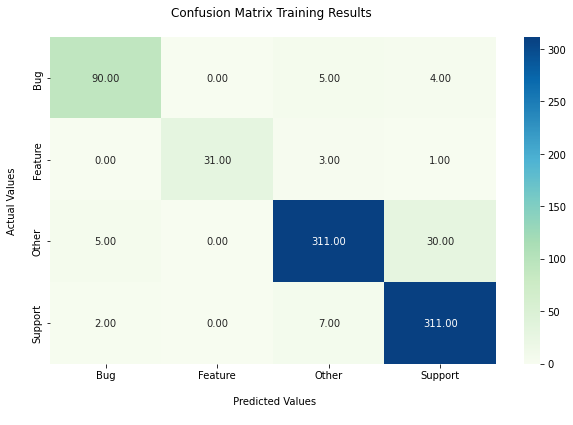


Classification Report:
              precision    recall  f1-score   support

         Bug       0.93      0.91      0.92        99
     Feature       1.00      0.89      0.94        35
       Other       0.95      0.90      0.93       346
     Support       0.90      0.97      0.93       320

    accuracy                           0.93       800
   macro avg       0.95      0.92      0.93       800
weighted avg       0.93      0.93      0.93       800


VALIDATION RESULTS:

Confusion Matrix:


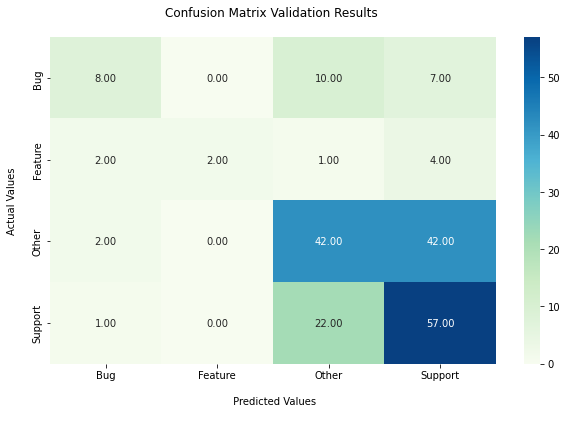


Classification Report:
              precision    recall  f1-score   support

         Bug       0.62      0.32      0.42        25
     Feature       1.00      0.22      0.36         9
       Other       0.56      0.49      0.52        86
     Support       0.52      0.71      0.60        80

    accuracy                           0.55       200
   macro avg       0.67      0.44      0.48       200
weighted avg       0.57      0.55      0.53       200



In [ ]:
# PRECISION
# Precision can be seen as a measure of a classifier’s exactness.
# For each class, it is defined as the ratio of true positives to the sum of true and false positives. 
# Said another way, “for all instances classified positive, what percent was correct?”

# RECALL
# Recall is a measure of the classifier’s completeness; 
# the ability of a classifier to correctly find all positive instances. 
# For each class, it is defined as the ratio of true positives to the sum of true positives and false negatives. 
# Said another way, “for all instances that were actually positive, what percent was classified correctly?”

# F1 SCORE
# The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 
# Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation.
# As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

# SUPPORT
# Support is the number of actual occurrences of the class in the specified dataset. 
# Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and 
# could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead 
# diagnoses the evaluation process.

# CONFUSION MATRIX
# https://medium.com/mlearning-ai/confusion-matrix-for-multiclass-classification-f25ed7173e66
# From the confusion matrix, we can calculate TP, TN, FP, and FN for each class. 
# By using these values, we can calculate precision, recall, and f1-score.

# CLASSIFICATION REPORT
# The classification report will display the performance metrics of the classification model. 
# It will display metrics like precision, recall,f1-score, and support for each class. 
# It also displays metrics like accuracy, macro avg, and weighted avg.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("TRAINING RESULTS:\n")
y_pred_train = mnb.predict(X_train_trans)

print("Confusion Matrix:")
confusion_matrix_train = confusion_matrix(y_train,y_pred_train)
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix_train, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix Training Results \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['Bug', 'Feature', 'Other', 'Support'])
fx.yaxis.set_ticklabels(['Bug', 'Feature', 'Other', 'Support'])
plt.show()

print("\nClassification Report:")
print(classification_report(y_train,y_pred_train,zero_division=0))


print("\nVALIDATION RESULTS:\n")
y_pred_val = mnb.predict(X_val_trans)

print("Confusion Matrix:")
confusion_matrix_val = confusion_matrix(y_val,y_pred_val)

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix_val, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix Validation Results \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['Bug', 'Feature', 'Other', 'Support'])
fx.yaxis.set_ticklabels(['Bug', 'Feature', 'Other', 'Support'])
plt.show()

print("\nClassification Report:")
print(classification_report(y_val,y_pred_val,zero_division=0))

In [ ]:
#Rename table for readability
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = grid_cv_results[column_results]

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

#rename table
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,alpha,ngram_range,min_df,mean_test_score,std_test_score,rank_test_score
0,0.01,"(1, 1)",1,0.52750,0.022569,35
1,0.1,"(1, 1)",1,0.53125,0.023717,32
2,1,"(1, 1)",1,0.53125,0.026517,32
3,10,"(1, 1)",1,0.54625,0.025800,6
4,100,"(1, 1)",1,0.43625,0.009186,40
5,0.01,"(1, 2)",1,0.54125,0.029208,17
6,0.1,"(1, 2)",1,0.54000,0.041571,19
7,1,"(1, 2)",1,0.53625,0.029155,28
8,10,"(1, 2)",1,0.53750,0.018114,27
9,100,"(1, 2)",1,0.43750,0.005590,39


In [ ]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["alpha"],
    columns=["ngram_range"])

pivoted_cv_results

ngram_range,"(1, 1)","(1, 2)","(1, 3)"
alpha,,,
0.01,0.528750,0.543333,0.537083
0.10,0.538333,0.547917,0.542917
1.00,0.540000,0.536667,0.541250
10.00,0.544167,0.540833,0.546250
100.00,0.440833,0.435833,0.435417


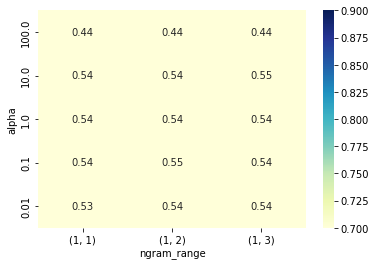

In [ ]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

# Suggested TODOS
1. Grid Search Heatmap. If our parameters are at the edge, adjust them and re-run grid seach. Otherwise, move on.
1. Confusion Matrix between classifications. Where was the model making the most mistakes?
1. Feature Importances. Anything stand out as interesting?
1. Other visualizations?
1. Analysis on model outcomes, excuses for why our results were terrible.
1. Could try different model types. A different grid search would have to be performed for each, I don't think you can easily grid search with different types of models all in one.
1. Anything else you guys can think of
